# DM Etude thermique

- author : Sylvie Dagoret-Campagne
- afflilation : LAL/IJCLab, CNRS
- creation date : Mars 14th 2021
- update : 
 

## Table des constantes de astropy
https://docs.astropy.org/en/stable/constants/

In [263]:
from astropy import constants as const

In [264]:
from astropy.constants import m_e,c,eps0,e,R_sun

In [265]:
from astropy import units as u

In [266]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [267]:
import numpy as np
import re
import time
from datetime import datetime,date
import dateutil.parser
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import Angle
from astropy import units as u

In [268]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors as colors
import matplotlib.cm as cmx

In [269]:
matplotlib.rcParams.update({'font.size': 15, 'lines.linewidth': 2, 'lines.markersize': 15})
matplotlib.rcParams["axes.labelsize"]="small"
matplotlib.rcParams["axes.linewidth"]=2.0
matplotlib.rcParams["xtick.major.size"]=8
matplotlib.rcParams["ytick.major.size"]=8
matplotlib.rcParams["ytick.minor.size"]=5
matplotlib.rcParams["xtick.labelsize"]="large"
matplotlib.rcParams["ytick.labelsize"]="large"
matplotlib.rcParams["figure.figsize"]=(8,8)
matplotlib.rcParams['axes.titlesize'] = 15
matplotlib.rcParams['axes.titleweight'] = 'bold'
#matplotlib.rcParams['axes.facecolor'] = 'blue'
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
matplotlib.rcParams['lines.markersize'] = 10  # markersize, in points
matplotlib.rcParams['grid.alpha'] = 1. # transparency, between 0.0 and 1.0
matplotlib.rcParams['grid.linestyle'] = '-' # simple line
matplotlib.rcParams['grid.linewidth'] = 0.4 # in points 

In [270]:
from scipy import signal

In [271]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

# Preambule

## Question 1.1

In [272]:
a = 8.0
b = 5.
h = 2.5

In [273]:
Cv_air = 1.25e3 # J/m3/K

In [274]:
P = 2000. # W

### Question 1.1.a : capacité thermique de la piece 

In [275]:
C = Cv_air*a*b*h
C  # J/K

125000.0

### Question 1.1.b : Bilan thermique 

$$
P = C \frac{dT}{dt}
$$

### Question 1.1.c : Durée

In [276]:
T_i = 10 # degres
T_f = 20 # degres
Delta_T = T_f  - T_i

In [277]:
t= Delta_T*C/P

In [278]:
t

625.0

In [279]:
t/60

10.416666666666666

In [280]:
t-int(t/60)*60

25.0

$$
\Delta t = 10 min 25 secondes
$$

## Influence des murs

In [281]:
L=0.15 # m : epaissuer des murs

In [282]:
c_mur= 1e3 # J kg-1 K-1

In [283]:
rho_mur= 2.2e3 # kg/m3

In [284]:
cond_th_mur=1.5

### Question 1.2.a

In [285]:
S_p=2*(h)*(a+b)
S_p

65.0

In [286]:
Vb=S_p*L
Vb

9.75

In [287]:
M_mur=Vb*rho_mur # masse du mur en kg

In [288]:
C_mur = c_mur*M_mur 
C_mur  #  J/K

21450000.0

### Question 1.2.b

### Question 1.5.b

In [289]:
Rth_mur= 1/cond_th_mur*L/S_p
Rth_mur # résistance thermique du mur en K/W

0.0015384615384615382

### Question 1.7

In [308]:
Delta_T=10

In [310]:
P=Delta_T/Rth_mur
P

6500.000000000001

# Première partie : équation de la chaleur

# Deuxieme partie

In [301]:
alpha = 200
RC= Rth_mur * C_mur

In [291]:
def H(x):
    y = (1+1j/4*alpha*x)/(1 + 1j*RC*x*(1+alpha/2)-alpha/4*RC**2*x**2)
    return y

In [292]:
def Mod(x):
    return np.abs(H(x))

In [293]:
def Arg(x):
    
    realpart = np.real(H(x))
    imagpart = np.imag(H(x))
    
    #angle = np.where(realpart > 0, np.angle(H(x)),  np.angle(H(x)) )
    
    angle = np.angle(H(x))
    
    return angle

In [294]:
X = np.logspace(-5,5,500,base=10)

In [295]:
G = Mod(X)

In [296]:
Phi= Arg(X)*180./np.pi

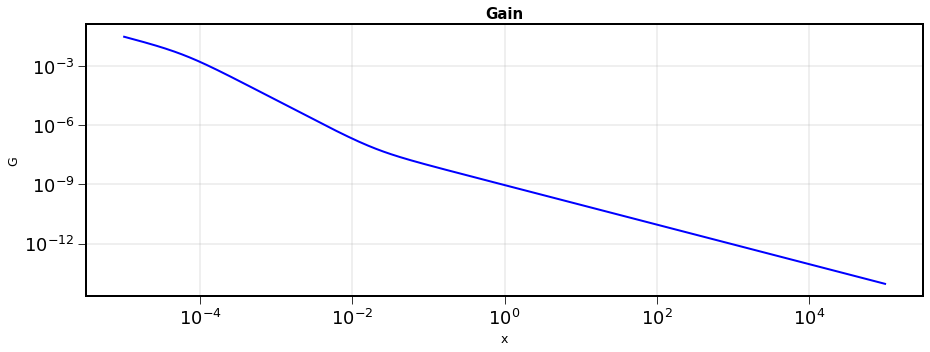

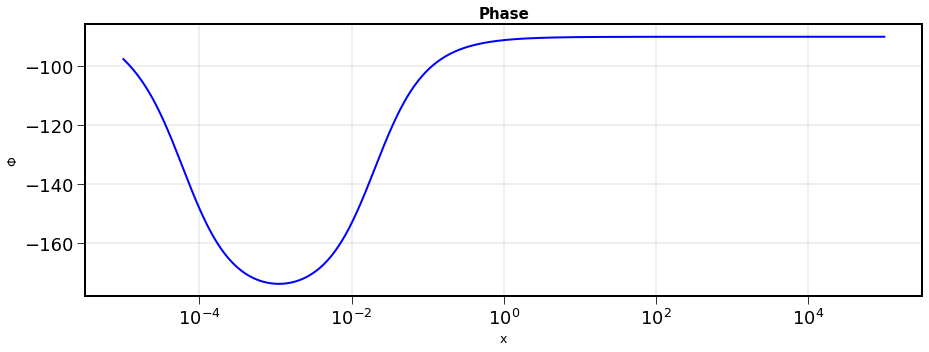

In [297]:
# Gain
plt.figure(figsize=(15,5))
plt.loglog(X,G,"b-")
plt.grid()
plt.xlabel("x")
plt.ylabel("G")
plt.title("Gain")
plt.show()

# Phase
plt.figure(figsize=(15,5))
plt.semilogx(X,Phi,"b-")
plt.grid()
plt.xlabel("x")
plt.ylabel("$\\Phi$")
plt.title("Phase")
plt.show()

# Troisieme partie

In [305]:
e=0.05
cond_th_is=0.05

In [306]:
Rth_is=1/cond_th_is*e/S_p
Rth_is

0.015384615384615385

In [307]:
Rth_mur

0.0015384615384615382

In [311]:
P=Delta_T/(Rth_mur+Rth_is)
P

590.9090909090909

##### 600 W, on gagne un facteur 10 de la puissance consomée